In [1]:
import threeDrebuild 
acad=threeDrebuild.acad
lines=threeDrebuild.lines
arcs=threeDrebuild.arcs
circles=threeDrebuild.circles


其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDb2LineAngularDimension
主视图有 90 条线段，32 个点
顶视图有 100 条线段，48 个点
右视图有 102 条线段，40 个点
3D点生成完毕，共 104 个点


In [2]:

import unfold.build_graph
import importlib
importlib.reload(unfold.build_graph)
from unfold.build_graph import get_graph
G_without_arcs,center_SEpair_map,center_arc_map=get_graph(lines,arcs)

第 1 个连通分量有 12 个节点，包含的弧有 4 条
第 2 个连通分量有 12 个节点，包含的弧有 2 条
第 3 个连通分量有 12 个节点，包含的弧有 1 条
第 4 个连通分量有 12 个节点，包含的弧有 1 条
第 5 个连通分量有 12 个节点，包含的弧有 1 条
第 6 个连通分量有 8 个节点，包含的弧有 1 条


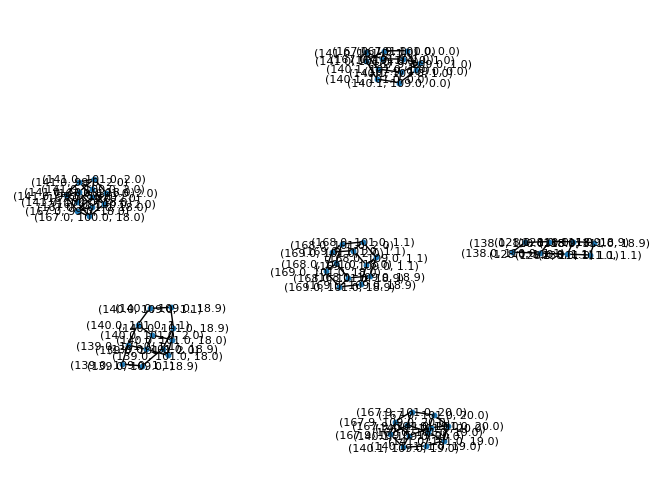

In [3]:
import unfold.build_compoment
import importlib
importlib.reload(unfold.build_compoment)
from unfold.build_compoment import get_component

component_arc_map,component_id_map,start_id=get_component(G_without_arcs,center_SEpair_map)



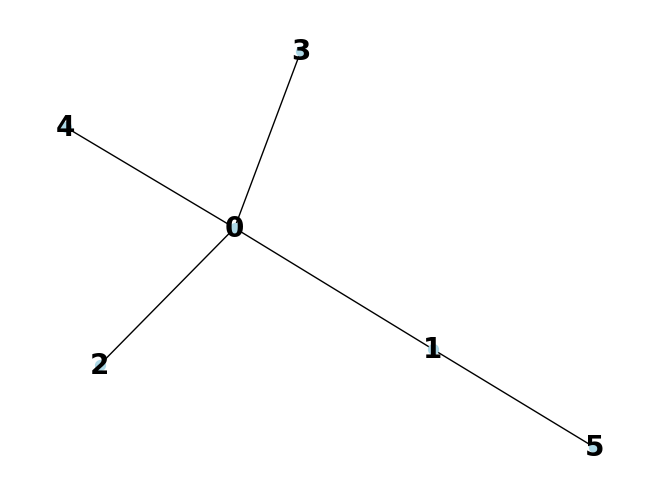

In [4]:
import unfold.build_compoment_graph
import importlib
importlib.reload(unfold.build_compoment_graph)
from unfold.build_compoment_graph import get_compoment_graph
graph=get_compoment_graph(component_arc_map)


In [5]:
import numpy as np
from  unfold.unfold_arc import UnfoldProcessor

print("其中 1 是红色，2 是黄色，3 是绿色，4 是蓝色，5 是紫色，6 是青色，7 是灰色，8 是白色")
visited = set()
last_transform = np.eye(4)  # 初始变换矩阵

processor = UnfoldProcessor(acad, lines,arcs,center_arc_map, component_id_map, circles)
processor.dfs(graph, start_id, visited, last_transform)

其中 1 是红色，2 是黄色，3 是绿色，4 是蓝色，5 是紫色，6 是青色，7 是灰色，8 是白色
2


COMError: (-2147352573, '找不到成员。', (None, None, None, 0, None))